
# LangGraph Memory Management Tutorial - Part-3

In this notebook, we'll explore **Memory Management in LangGraph** using a real-life example.  
We will cover:
- Basics of LangGraph memory
- Why memory management is important
- Example: Travel Booking Assistant with and without memory
- Visualization of how memory works inside LangGraph

We'll use **Gemini 1.5 Flash** model for responses instead of GPT-4o.



# Travel Assistant Agent with Memory

This notebook demonstrates how to build a **Travel Agent Assistant** using **LangGraph**, showcasing two important aspects:

1. **Without Memory vs With Memory** – to see how conversations differ when no context is stored compared to when memory is maintained across turns.  
2. **Summarized Memory with "Should Continue" Agent** – to optimize memory usage by summarizing past conversations while retaining key details.

Both concepts are integrated into a single flow, so you can see how a travel assistant agent can evolve from stateless interactions to context-aware and memory-efficient conversations.




- **LangGraph Memory Basics**
  - Memory allows agents to remember past interactions.
  - Without memory, every user input is treated independently.
  - With memory, agents can reference earlier parts of the conversation.

- **Why Memory is Required**
  - Makes interactions natural (like humans do).
  - Helps in multi-turn conversations (e.g., booking flights, shopping, recommendations).
  - Reduces repetition — user doesn’t need to repeat details.

- **Types of Memory**
  - **Stateless** → No history, each query independent.
  - **Stateful (with memory)** → Maintains context across turns.


In [1]:
%pip install --quiet -U langchain_core langgraph langchain_openai graphviz langchain_google_genai langchain

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os

os.environ["LANGSMITH_API_KEY"] = 'your_langsmith_key'
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "AaiTech-LangGraph"
os.environ["GOOGLE_API_KEY"] = "your_gemini_key"

In [3]:
from langchain.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI

# Setup Gemini 1.5 Flash model
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0)

# Define prompt for Travel Assistant

travel_prompt = ChatPromptTemplate.from_template("""
You are a **simple travel assistant**.

Rules:
- If the user mentions a destination, acknowledge it clearly.
- If the user asks follow-up questions (like "when should I go there?"),
  you must answer based on the remembered destination.
- If no destination is known (stateless case), say:
  "I don't know where you want to go yet. Please tell me your destination."

Keep answers short, clear, and friendly.
Conversation so far:
{messages}
""")


# Create the chain
travel_chain = travel_prompt | llm


### Without Memory

In [4]:
from langgraph.graph import StateGraph, MessagesState

stateless_graph = StateGraph(MessagesState)

@stateless_graph.add_node
def travel_agent(state: MessagesState):
    response = travel_chain.invoke({"messages": state["messages"]})
    return {"messages": state["messages"] + [response]}

stateless_graph.set_entry_point("travel_agent")
stateless_graph.set_finish_point("travel_agent")

stateless_app = stateless_graph.compile()

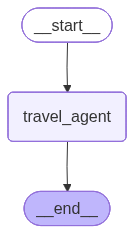

In [5]:
# Visualize the graph structure
from IPython.display import Image

# Draw the graph
stateless_graph_image = stateless_app.get_graph().draw_mermaid_png()

# Display it
Image(stateless_graph_image)


In [6]:
# Run conversation without memory
messages = [{"role": "user", "content": "I want to go to Goa, please help me with the Itinerary"}]
print(stateless_app.invoke({"messages": messages})["messages"][-1].content)

Okay, Goa!  I can help you with an itinerary.  What kind of things are you interested in doing there?


In [7]:
messages = [{"role": "user", "content": "What are the good places to visit?"}]
print(stateless_app.invoke({"messages": messages})["messages"][-1].content)


I don't know where you want to go yet. Please tell me your destination.


### With Memory

In [8]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
with_memory_graph = StateGraph(MessagesState)

@with_memory_graph.add_node
def travel_agent(state: MessagesState):
    response = travel_chain.invoke({"messages": state["messages"]})
    return {"messages": state["messages"] + [response]}

with_memory_graph.set_entry_point("travel_agent")
with_memory_graph.set_finish_point("travel_agent")

with_memory_app = with_memory_graph.compile(checkpointer=memory)

# Run conversation with memory
thread = "user1"

## Threads

The checkpointer saves the state at each step as a checkpoint.

These saved checkpoints can be grouped into a `thread` of conversation.

Think about Slack as an analog: different channels carry different conversations.

Threads are like Slack channels, capturing grouped collections of state (e.g., conversation).

Below, we use `configurable` to set a thread ID.

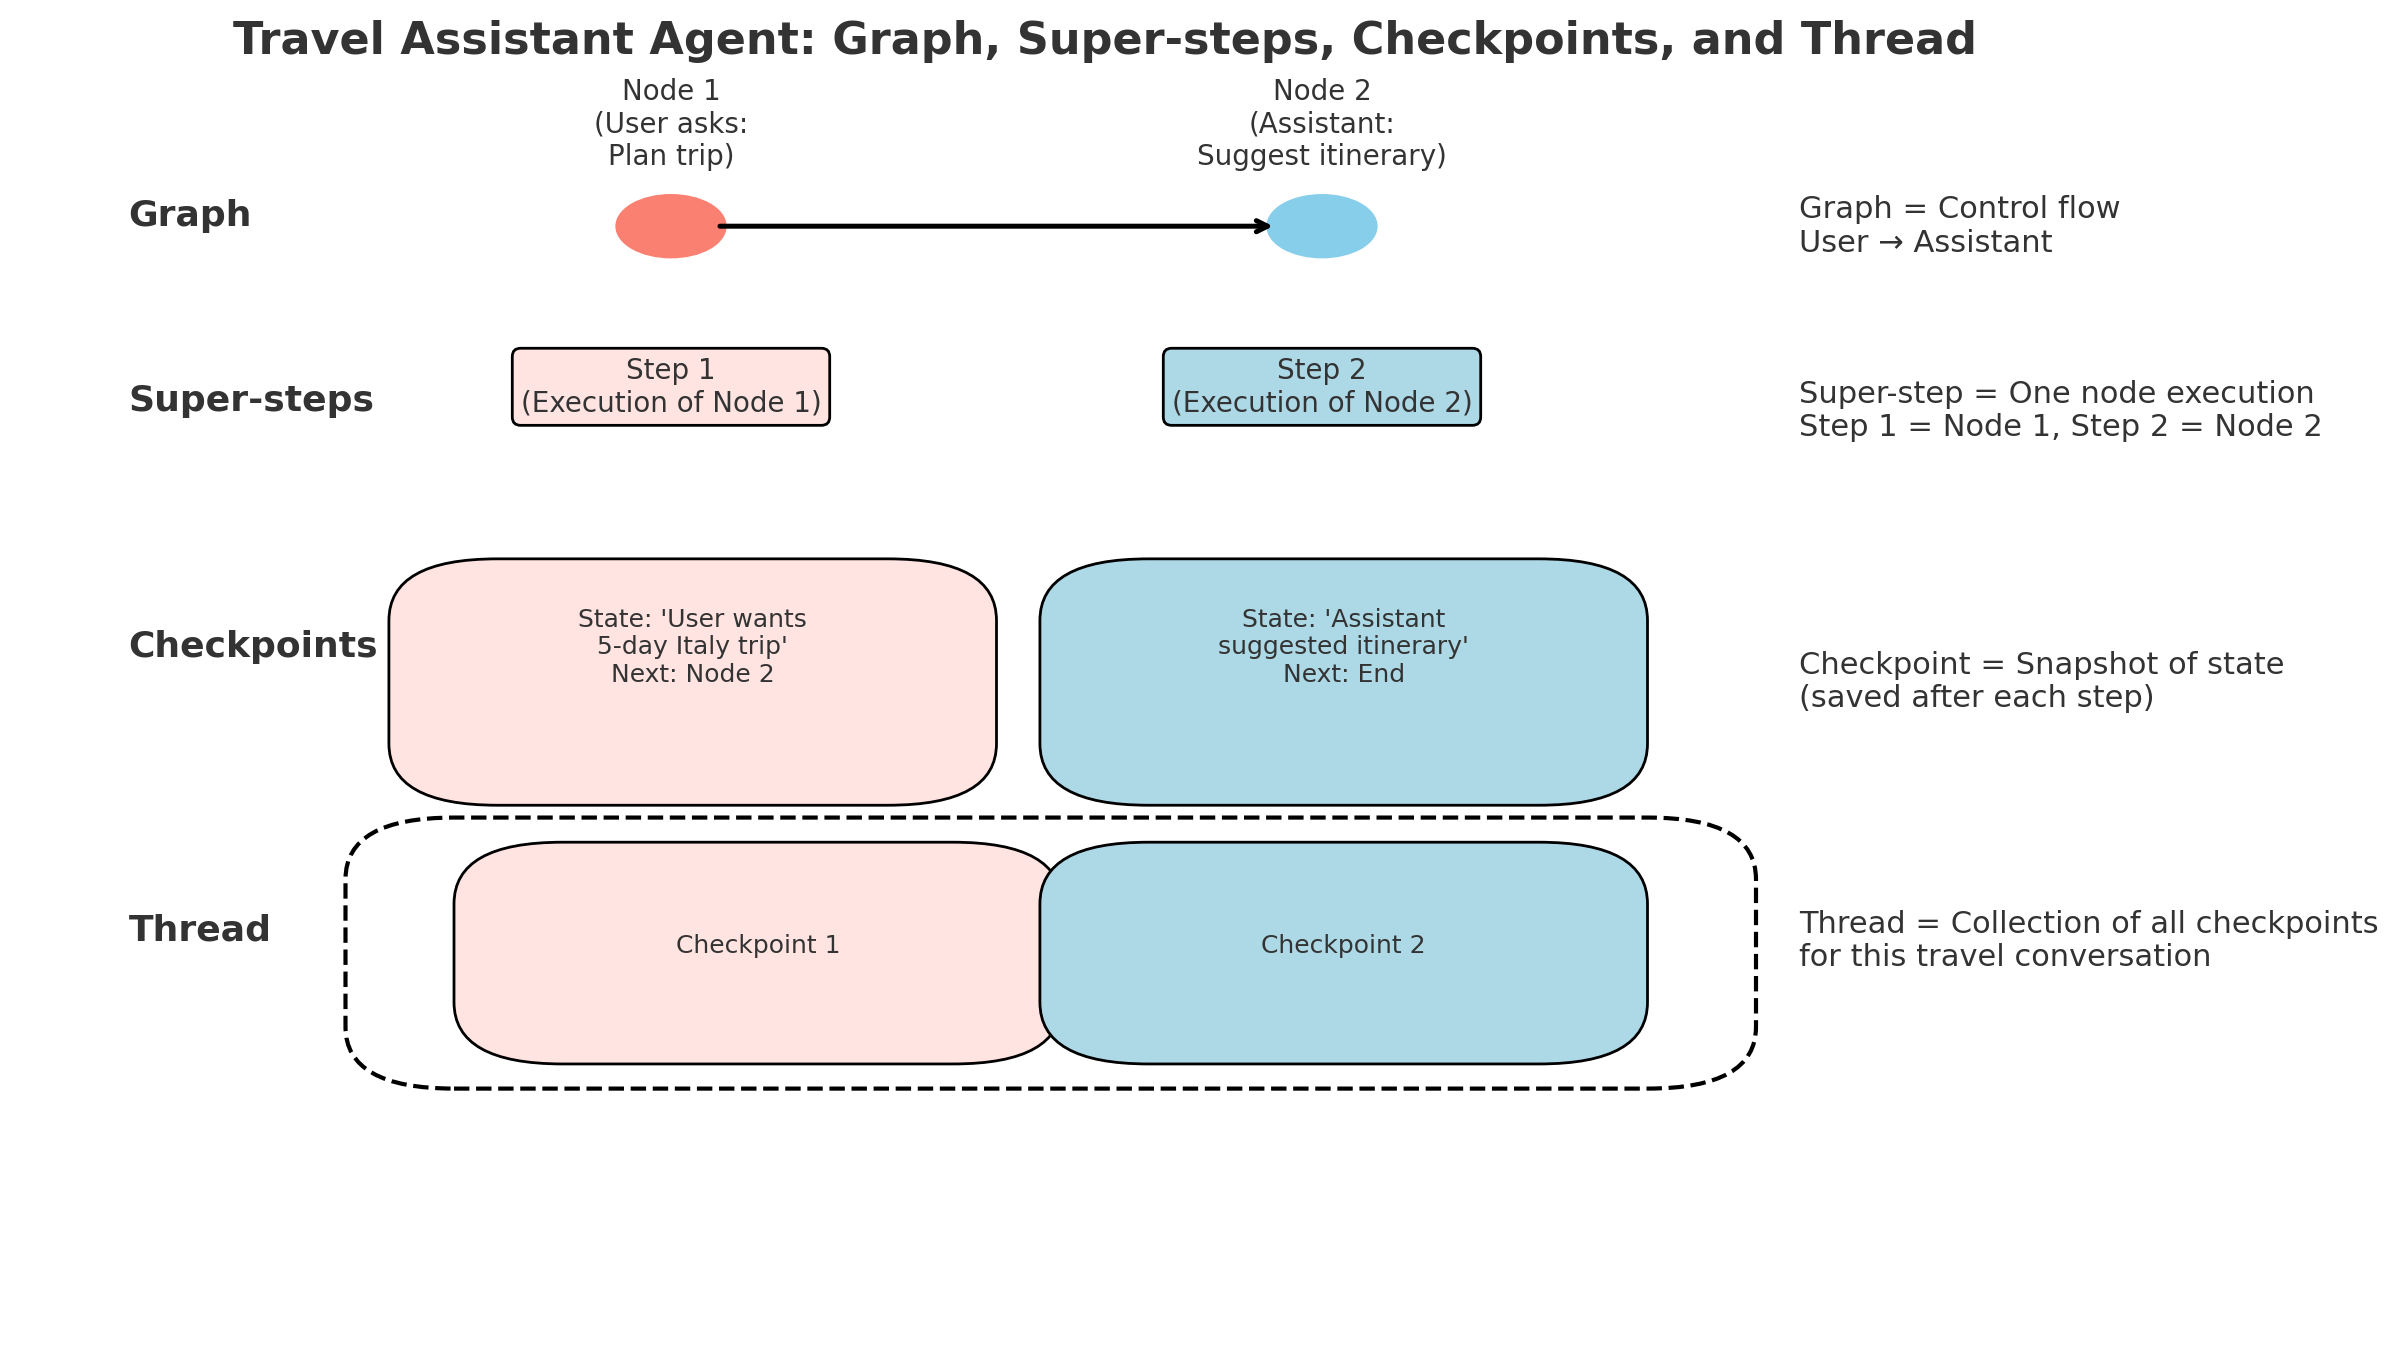


```mermaid
graph TD
    User["User Input"] --> Agent["Travel Agent Node"]
    Agent --> Response["Assistant Response"]
    Agent -->|Save context| Memory["MemorySaver (Checkpoint)"]
    Memory -->|Recall context| Agent
    Response --> User
```

In [9]:
messages = [{"role": "user", "content": "I want to go to Goa, please help me with the Itinerary"}]
print(with_memory_app.invoke({"messages": messages}, config={"configurable":{"thread_id": thread}})["messages"][-1].content)

Okay, Goa!  I can help you with an itinerary.  What kind of things are you interested in doing there?


In [10]:
messages = [{"role": "user", "content": "What are the good places to visit?"}]
print(with_memory_app.invoke({"messages": messages}, config={"configurable":{"thread_id": thread}})["messages"][-1].content)

Okay, Goa!  Some good places to visit in Goa include Palolem Beach, Old Goa, and Dudhsagar Falls.



---

## Extending with Summarized Memory

In the previous section, we saw how the travel agent works **with and without memory**.  
Now, we will integrate the concept of a **"Should Continue Agent"**, which helps in managing memory efficiently by summarizing past conversations.

This allows the Travel Assistant to keep track of context **without overloading memory**, ensuring scalability and long-running interactions.




### Why Do We Need Summarization in Memory?

You may wonder: *If LangGraph already provides memory classes to store conversation history, why do we need summarization?*  

The answer lies in **scalability and efficiency**:

- **Memory Growth Problem**: If we keep appending full conversation history, the memory grows very large over time. This leads to slower responses and higher computation costs.  
- **Relevance Filtering**: Not every past detail is equally important. Summarization ensures that only the **essential context** is carried forward.  
- **Long Conversations**: In a travel assistant scenario, a user may have dozens of interactions (planning flights, hotels, activities, etc.). Without summarization, the assistant would struggle to process all the stored text efficiently.  
- **Improved Reasoning**: Summarized memory helps the model stay focused on the **core details** (destination, preferences, constraints) instead of being distracted by irrelevant chat history.  

Hence, summarization acts as a **memory compression mechanism**, allowing the assistant to remain **context-aware** while still being efficient and scalable.


We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [11]:
from langchain.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI

# Setup Gemini 1.5 Flash model
model = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0)

We'll use `MessagesState`, as before.

In addition to the built-in `messages` key, we'll now include a custom key (`summary`).

In [13]:
from langgraph.graph import MessagesState
class State(MessagesState):
    summary: str

We'll define a node to call our LLM that incorporates a summary, if it exists, into the prompt.

In [14]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

We'll define a node to produce a summary.

Note, here we'll use `RemoveMessage` to filter our state after we've produced the summary.

In [15]:
def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

We'll add a conditional edge to determine whether to produce a summary based on the conversation length.

In [16]:
from langgraph.graph import END
from typing_extensions import Literal
# Determine whether to end or summarize the conversation
def should_continue(state: State) -> Literal ["summarize_conversation",END]:
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

## Adding memory

Recall that [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

This limits our ability to have multi-turn conversations with interruptions. 

As introduced at the end of Module 1, we can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this! 
 
LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update. 

As we previously showed, one of the easiest to work with is `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is compile the graph with a checkpointer, and our graph has memory!

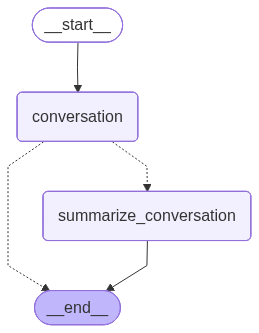

In [17]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="I want to go to Goa, please help me with the Itinerary")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="Where can I stay?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="What water sports I should try?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

To help me create the perfect Goa itinerary for you, I need some more information!  Tell me about:

* **Trip Length:** How many days will you be in Goa?
* **Travel Style:**  Relaxing beach vacation?  Adventure-packed trip?  Cultural exploration?  Partying? A mix?
* **Budget:**  Luxury, mid-range, or budget-friendly? This will influence accommodation and activity choices.
* **Time of Year:**  Goa's weather varies significantly throughout the year.  Knowing the time of year will help me suggest appropriate activities.
* **Interests:**  What are you most interested in seeing and doing? (e.g., beaches, historical sites, nightlife, water sports, nature, food, etc.)
* **Travel Companions:**  Are you traveling solo, as a couple, with friends, or with family (including children)?  This will influence the types of activities and accommodations I suggest.


Once I have this information, I can create a personalized 

Now, we don't yet have a summary of the state because we still have < = 6 messages.

This was set in `should_continue`. 

```
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
```

We can pick up the conversation because we have the thread.

In [19]:
graph.get_state(config).values.get("summary","")

''

The `config` with thread ID allows us to proceed from the previously logged state!

In [20]:
input_message = HumanMessage(content="Are there any museums that I should visit?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Goa has a rich history, reflected in its diverse museums.  Here are a few you should consider visiting, categorized for easier planning:

**In Old Goa (a must-visit area for history buffs):**

* **Goa State Museum:** Located in Panjim (Panaji), this museum houses a comprehensive collection of Goan artifacts, including sculptures, paintings, and historical documents, showcasing the state's diverse cultural heritage.  It's a good starting point for understanding Goan history.
* **Archaeological Museum:** Also in Old Goa, this museum focuses specifically on archaeological finds from the region, offering insights into Goa's past civilizations.


**Other Notable Museums:**

* **Naval Aviation Museum:** Located near Dabolim Airport, this museum is a treat for aviation enthusiasts.  It showcases the history of naval aviation in India, with various aircraft and exhibits.
* **Big Foot Museum:**  A quirky and uniqu

In [21]:
graph.get_state(config).values.get("summary","")

"This conversation planned a trip to Goa, India.  We first determined the need for trip specifics (length, budget, travel style, interests, and travel companions) to create a personalized itinerary.  Then, we discussed accommodation options in North and South Goa, ranging from budget guesthouses to luxury resorts, emphasizing the need for specifying budget and preferred atmosphere.  Next, we explored various water sports available, categorizing them by thrill level and suggesting considerations like season and safety. Finally, we discussed several museums in Goa, including the Goa State Museum, the Archaeological Museum in Old Goa, the Naval Aviation Museum, and the Big Foot Museum, advising on planning based on personal interests and time constraints.  The overall goal was to create a detailed and personalized Goa travel plan based on the user's preferences."

In [22]:
input_message = HumanMessage(content="What about cruise safari?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Goa offers several types of cruise safaris, each providing a different experience.  To recommend the best one for you, I need a little more information about your preferences:

* **What kind of atmosphere are you looking for?**  Romantic, family-friendly, adventurous, or something else?
* **What's your budget?**  Prices vary significantly depending on the duration, amenities, and inclusions.
* **What time of year are you visiting?**  Sea conditions can affect the availability and suitability of certain cruises.
* **What are your interests?**  Are you interested in sightseeing, dolphin watching, sunset views, or something else?


Generally, Goa's cruise safaris fall into these categories:

* **Sunset Cruises:** These are popular for their romantic ambiance, offering stunning views of the Goan coastline as the sun sets.  They often include drinks and snacks.
* **Dolphin Watching Cruises:**  These cruises fo